# Classification. Linear models and KNN

In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [7]:
PATH = "./data/"

In [8]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [9]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [49]:
survived = data[data.Survived == 1]
males, females = (data[data.Sex == 'male'].shape[0], data[data.Sex == 'female'].shape[0])
males_surv, females_surv = (survived[survived.Sex == 'male'].shape[0], survived[survived.Sex == 'female'].shape[0])
'Male: {} (survived {}), female: {} (survived {})'.format(males, males_surv, females, females_surv)

'Male: 577 (survived 109), female: 314 (survived 233)'

Yes, more women survived, apparently due to the fact that they were let forward during the evacuation.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

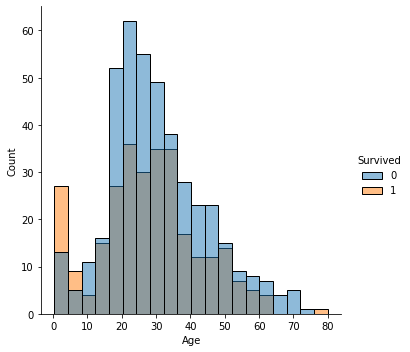

Survived mean: 28.343689655172415, survived median: 28.0
Deceased mean: 30.62617924528302, deceased median: 28.0


In [85]:
age_data = data.dropna(subset=['Age'])
age_survived, age_deceased = age_data[age_data.Survived == 1], age_data[age_data.Survived == 0]
sns.displot(age_data, x='Age', hue='Survived')
plt.show()
print('Survived mean: {}, survived median: {}'.format(age_survived.Age.mean(), age_survived.Age.median()))
print('Deceased mean: {}, deceased median: {}'.format(age_deceased.Age.mean(), age_deceased.Age.median()))

Yes, the age distribution is different, because children, like womens, were the first to be evacuated.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

Safest class is: 1, percent of survived is: 62.62
Safest port is: C (Cherbourg), percent of survived is: 55.36


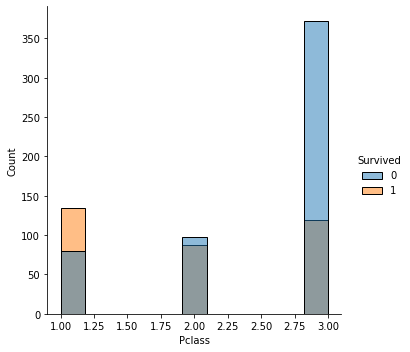

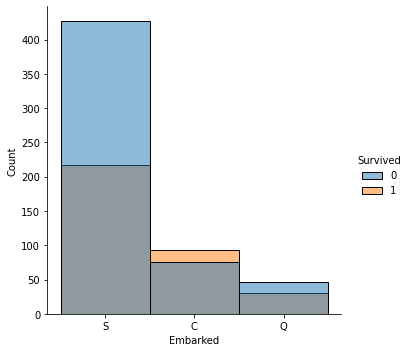

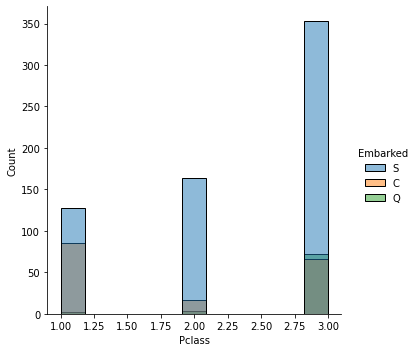

In [187]:
em_data = data.dropna(subset=['Embarked'])
survived_by_class = em_data.groupby('Pclass').agg(Count=('Pclass', 'count'), Survived=('Survived', 'sum'))
survived_by_class['Percent'] = (survived_by_class.Survived * 100) / survived_by_class.Count
print('Safest class is: {}, percent of survived is: {:.2f}'.format(
    survived_by_class['Percent'].idxmax(),
    survived_by_class['Percent'].max()
))
survived_by_embarked = em_data.groupby('Embarked').agg(Count=('Embarked', 'count'), Survived=('Survived', 'sum'))
survived_by_embarked['Percent'] = (survived_by_embarked.Survived * 100) / survived_by_embarked.Count
ports = {
    'C': 'Cherbourg',
    'Q': 'Queenstown',
    'S': 'Southampton',
}
print('Safest port is: {} ({}), percent of survived is: {:.2f}'.format(
    survived_by_embarked['Percent'].idxmax(),
    ports[survived_by_embarked['Percent'].idxmax()],
    survived_by_embarked['Percent'].max()
))
sns.displot(em_data, x='Pclass', hue='Survived')
plt.show()
sns.displot(em_data, x='Embarked', hue='Survived')
plt.show()
sns.displot(em_data, x='Pclass', hue='Embarked')
plt.show()

There is a relationship between port of embarkation and survival, but it is not very clear how these data are related.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [189]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_values = pd.DataFrame({'column_name': data.columns, 'percent_missing': percent_missing})
missing_values

,column_name,percent_missing
Survived,Survived,0.000000
Pclass,Pclass,0.000000
Name,Name,0.000000
Sex,Sex,0.000000
Age,Age,19.865320
SibSp,SibSp,0.000000
Parch,Parch,0.000000
Ticket,Ticket,0.000000
Fare,Fare,0.000000
Cabin,Cabin,77.104377


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Age data can be populated with averages, for example based on the average for the age of passengers in a suitable class, port of boarding, gender, etc. It is better to dump the column with the cabin number, since they are unique for almost every passenger and most of them are unknown.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [10]:
X = data.drop(columns=['Survived', 'Name', 'Ticket', 'Cabin'])
y = data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [17]:
num_features = ['Age', 'Fare']
num_trans = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

cat_features = ['Embarked', 'Sex', 'Pclass']
cat_trans = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('numeric', num_trans, num_features),
    ('category', cat_trans, cat_features)
])

pipe_knn = Pipeline([
    ('pre', preprocessor),
    ('clf', KNeighborsClassifier())
])
pipe_knn.fit(X_train, y_train)
knn_cv_results = cross_validate(pipe_knn, X_test, y_test, cv=3, scoring='accuracy')
knn_score = knn_cv_results['test_score'].mean()

pipe_lr = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression())
])
pipe_lr.fit(X_train, y_train)
lr_cv_results = cross_validate(pipe_lr, X_test, y_test, cv=3, scoring='accuracy')
lr_score = lr_cv_results['test_score'].mean()

print('KNN score: {}, LogisticRegression score: {}'.format(knn_score, lr_score))

KNN score: 0.786401429258572, LogisticRegression score: 0.8068095925238783


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [28]:
params = {
    'pre__numeric__imputer__strategy': ('mean', 'median', 'most_frequent'),
    'clf__n_neighbors': (3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25),
    'clf__weights': ('uniform', 'distance'),
    'clf__algorithm': ('auto', 'kd_tree'),
}
clf = GridSearchCV(pipe_knn, params)
search = clf.fit(X_train, y_train)
knn_cv_results = cross_validate(search.best_estimator_, X_test, y_test, cv=3, scoring='accuracy')
knn_cv_results['test_score'].mean()

0.7898027898027898

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [35]:
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
X_test_ = test_data.drop(columns=['Name', 'Ticket', 'Cabin'])
X_test_['Survived'] = search.best_estimator_.predict(X_test_)
X_test_[['Survived']].to_csv(os.path.join(PATH, 'titanic', 'predict.csv'))

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [18]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

FileNotFoundError: [Errno 2] No such file or directory: './data/porto\\train.csv'

In [ ]:
insurance_data.head()

Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [ ]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [ ]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [ ]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

In [ ]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [ ]:
insurance_data.describe()

As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

In [ ]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [ ]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [ ]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [ ]:
gini_normalized(y_valid, y_pred)

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [ ]:
## your code